### Import modules

In [1]:
# imports
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from functions_EDX import *

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors

from sklearn.metrics import DistanceMetric
import tifffile as tif

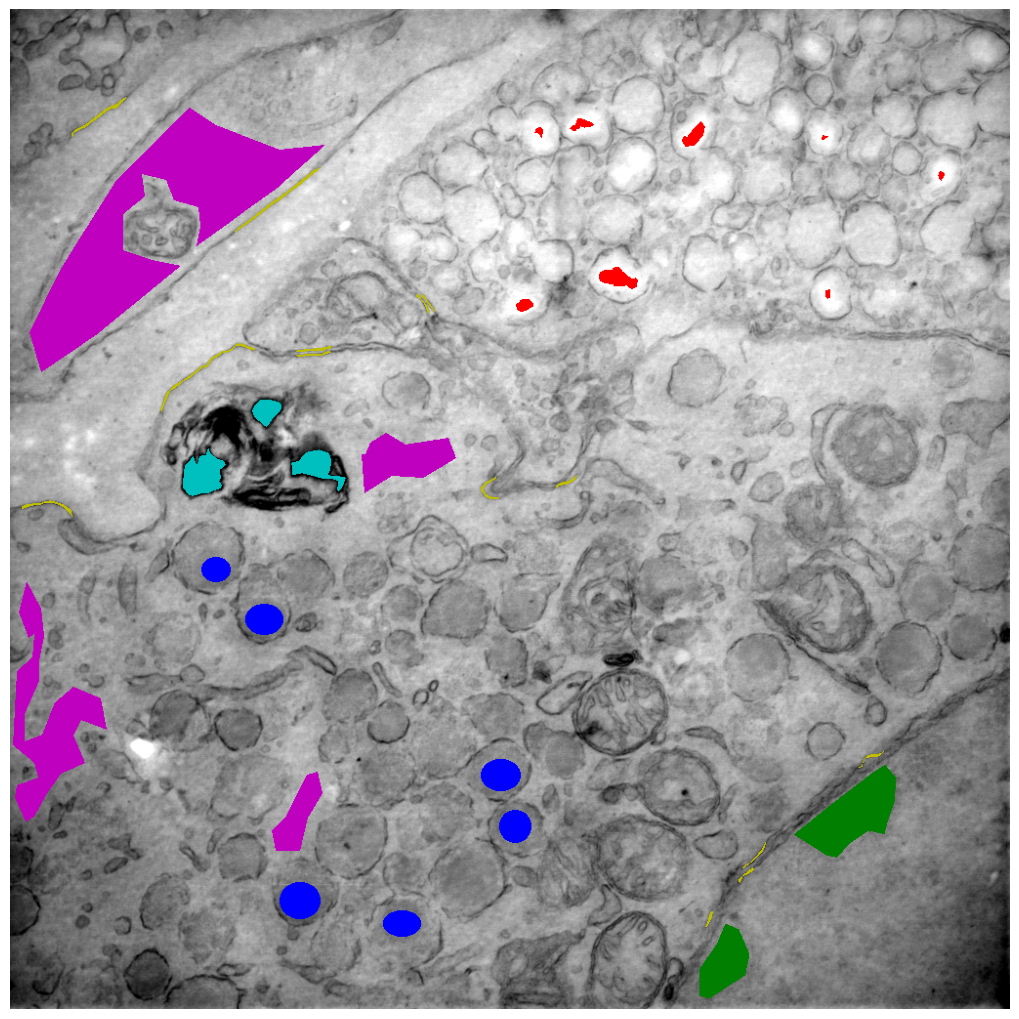

In [4]:
# load haadf
file_names = os.listdir('/Volumes/Microscopy3/EDX_data/old_datasets/NPZ')
file_names = [name for name in file_names if name.endswith('npz')]
file_names = sorted(file_names)
file_path = os.path.join('/Volumes/Microscopy3/EDX_data/old_datasets/NPZ',file_names[49])
loaded_file = np.load(file_path)
haadf = tif.imread('../data/Tile_00.tiff')  #rebin_XY(loaded_file['haadf'],1024)       
specrtrum_2D = loaded_file['spectrum']

size_xy = 1024
mask_dir = "../hand_annotated_masks"
file_names = os.listdir(mask_dir)
file_names = [name for name in file_names if name.endswith('tif')]
file_names.sort()

mask_paths = [os.path.join(mask_dir,file_name) for file_name in file_names]


colors = ['w','r','g','b','c','m','y']
newcmap = ListedColormap(colors)
all_masks = np.zeros((size_xy,size_xy),dtype='int')
for i in range(6):
    x = tif.imread(mask_paths[i])
    x = rebin_XY(x).astype('bool')
    all_masks = all_masks + x*(i+1)

# make an overlay image
colorsrgb = [mcolors.to_rgb(newcmap(i)) for i in range(newcmap.N)]  # the colors in the cmap
haadf_overlayed = np.repeat((normalize8(haadf)/255)[:, :, np.newaxis], 3, axis=2)
for i in range(1,7):
    haadf_overlayed[np.where(all_masks==i)[0],np.where(all_masks==i)[1]] = colorsrgb[i]


f,ax = plt.subplots(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
ax.imshow(haadf_overlayed)
#ax.set_title('Annotated masks')
#ax.set_title('HAADF')
plt.axis('off')
plt.savefig("../Results/annotated_haadf.png",dpi=300) #,bbox_inches='tight')

### Set the average spectra of the annotated areas as endmembers

In [6]:
# import the preprocessed spectrum array
spectrum_folder = '/Volumes/Microscopy4/EDX_data/old_datasets/Spectrum2D_extendedGauss1_3_5/'
file_names = []
tmp = os.listdir(spectrum_folder)
for filename in tmp:
    if filename.endswith('.npz'):
        file_names.append(filename)
file_names = sorted(file_names)
files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]
spectrum_2D = np.load(files[49])['spectrum_2D'][:,:250]
print(spectrum_2D.shape)

(1048576, 250)


In [7]:
# extract the endmembers from the masks
nEM = 6
endmembers = np.empty((250,nEM),float)
spectrum = np.reshape(spectrum_2D,(1024,1024,250))

for i in range(nEM):
    curr_mask = tif.imread(mask_paths[i])
    mask_idx = np.where(curr_mask)
    overlayed_spectrum = spectrum[mask_idx[0],mask_idx[1],:].mean(axis=0)
    endmembers[:,i] = overlayed_spectrum

### Compute abundance maps with NNLS

In [8]:
Ends = np.array([nnls(endmembers,i)[0] for i in spectrum_2D]).transpose()
Ends = Ends/np.max(Ends)

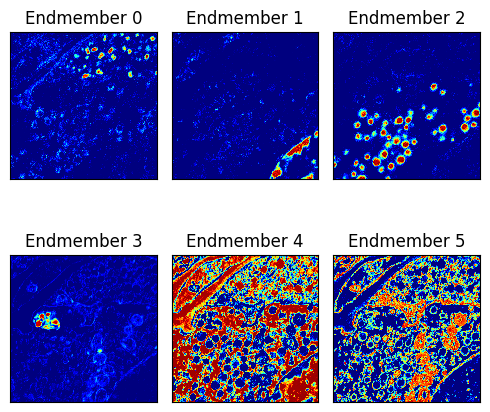

In [9]:
End_maps = np.reshape(Ends,(np.shape(Ends)[0],size_xy,size_xy))
%matplotlib inline 
cmap = 'jet'

rows = 2
cols = 3

fig, ax = plt.subplots(rows,cols,figsize=(5,5))
em_idx = 0
for i in range(rows):
    for j in range(cols):
        try:
            ax[i][j].imshow(End_maps[em_idx]*~overlap_corr(tile_idx=0,xy_dim=size_xy,rows=rows,cols=cols,overlap_ratio=0.20), interpolation='nearest',cmap=cmap, vmin = 0)
        except:
            ax[i][j].imshow(np.zeros((1024,1024)), interpolation='nearest',cmap=cmap, vmin = 0)
        ax[i][j].set_title('Endmember ' + str(em_idx))
        ax[i][j].axes.get_xaxis().set_visible(False)
        ax[i][j].axes.get_yaxis().set_visible(False)
    
        em_idx+=1
fig.tight_layout()    
plt.show()


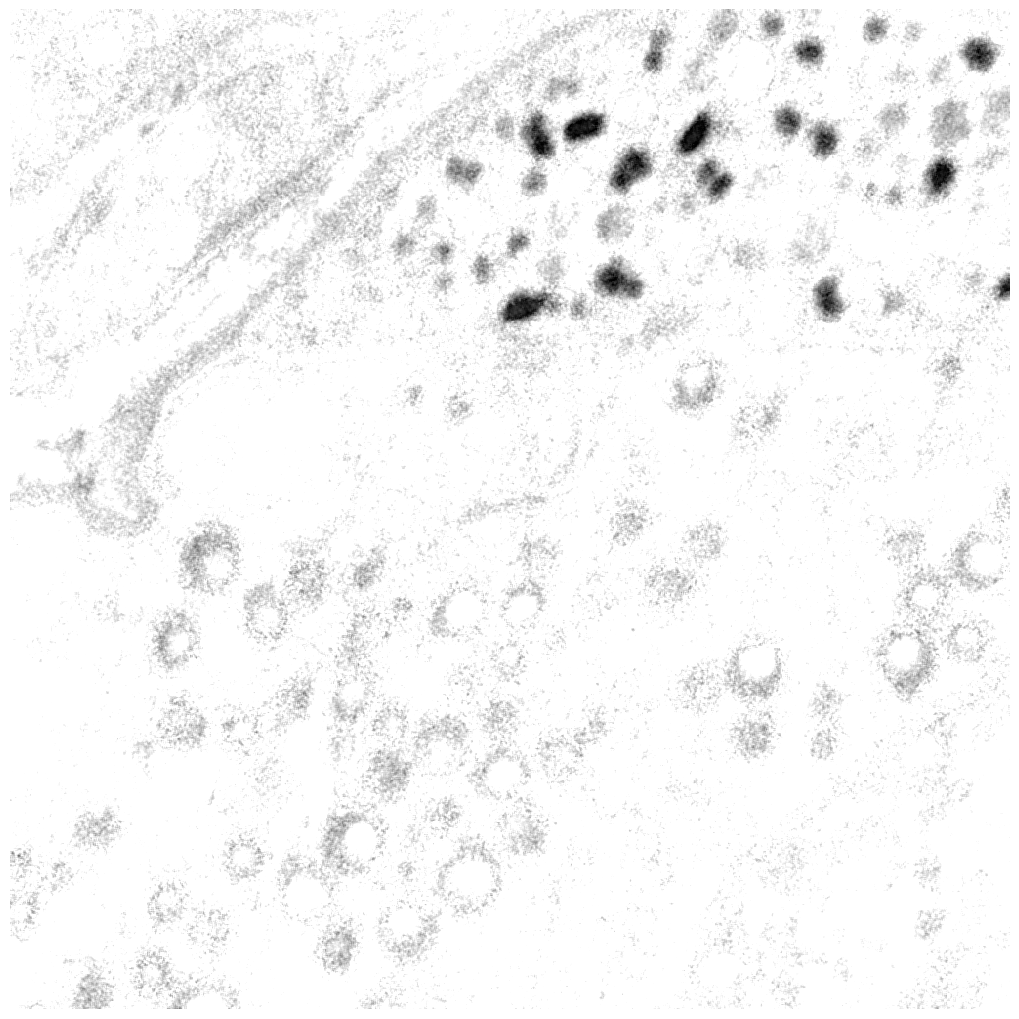

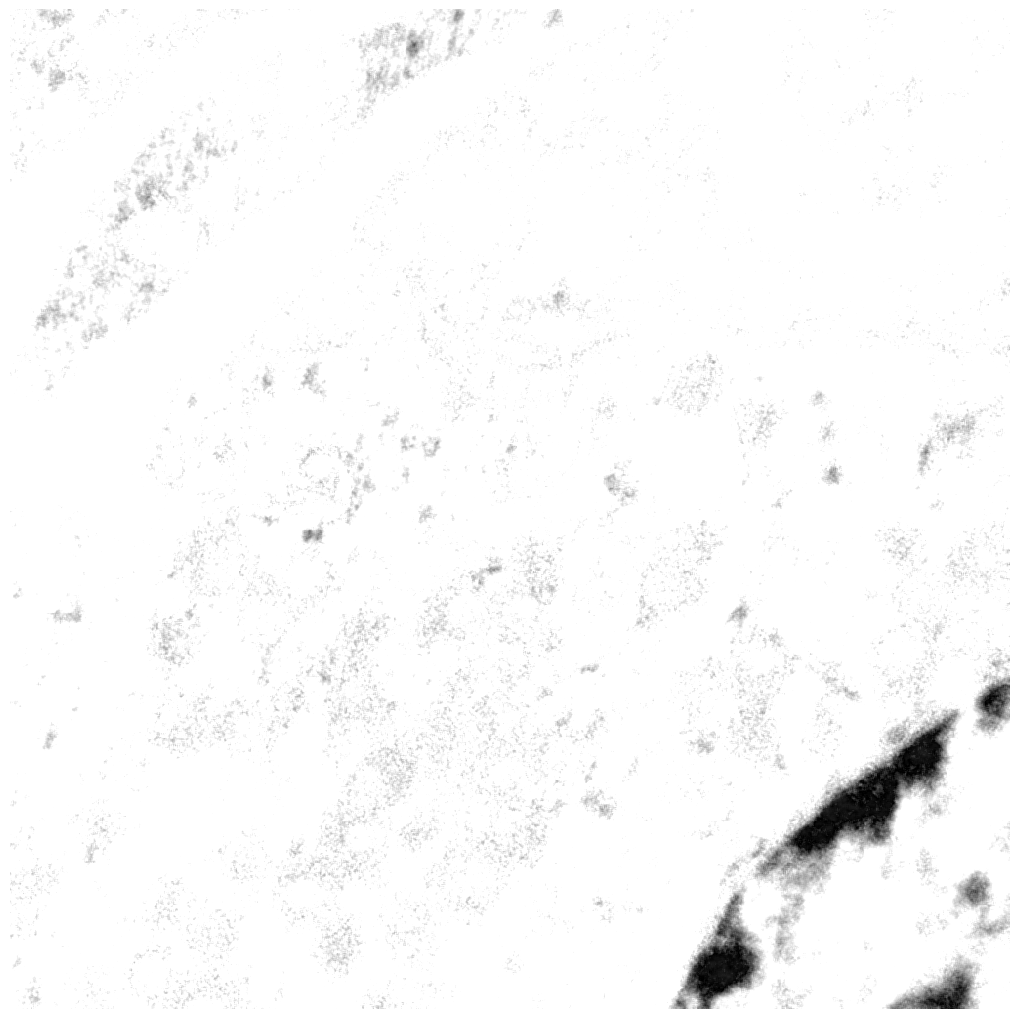

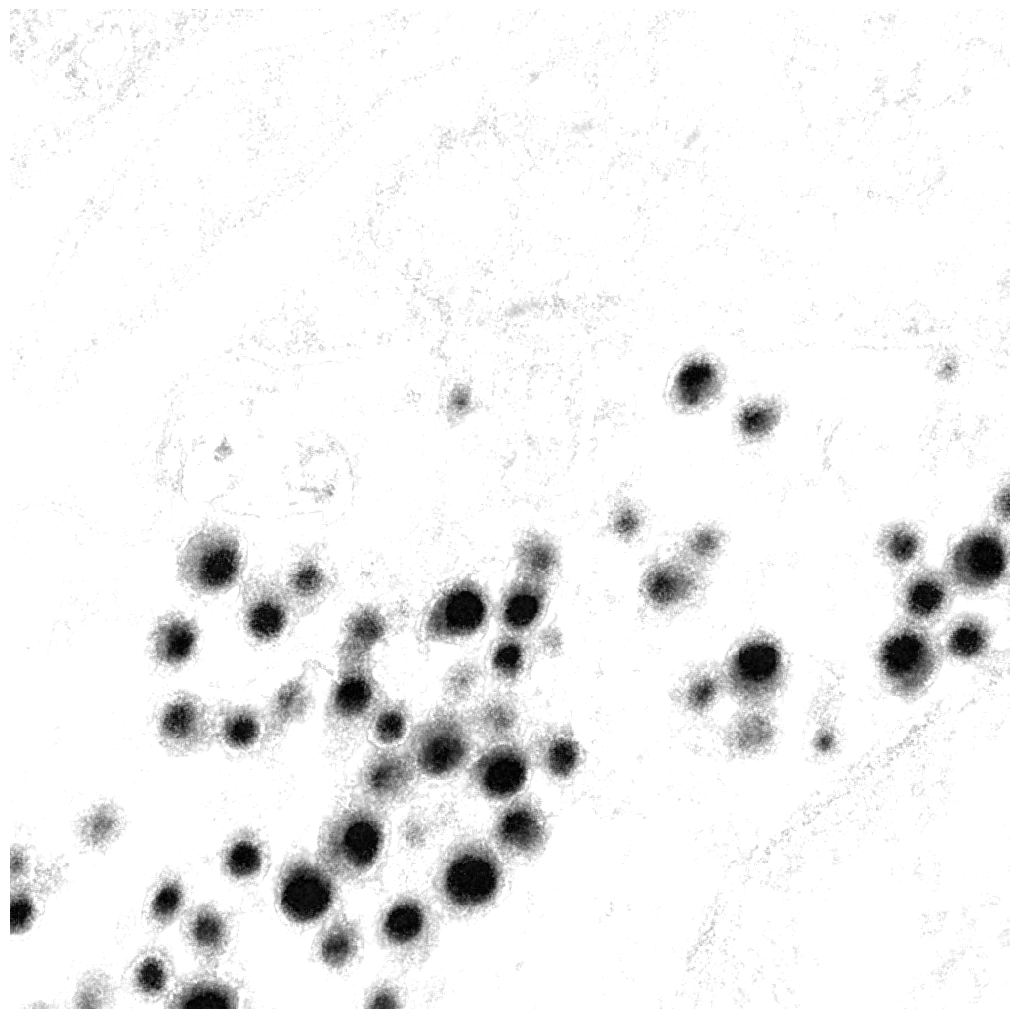

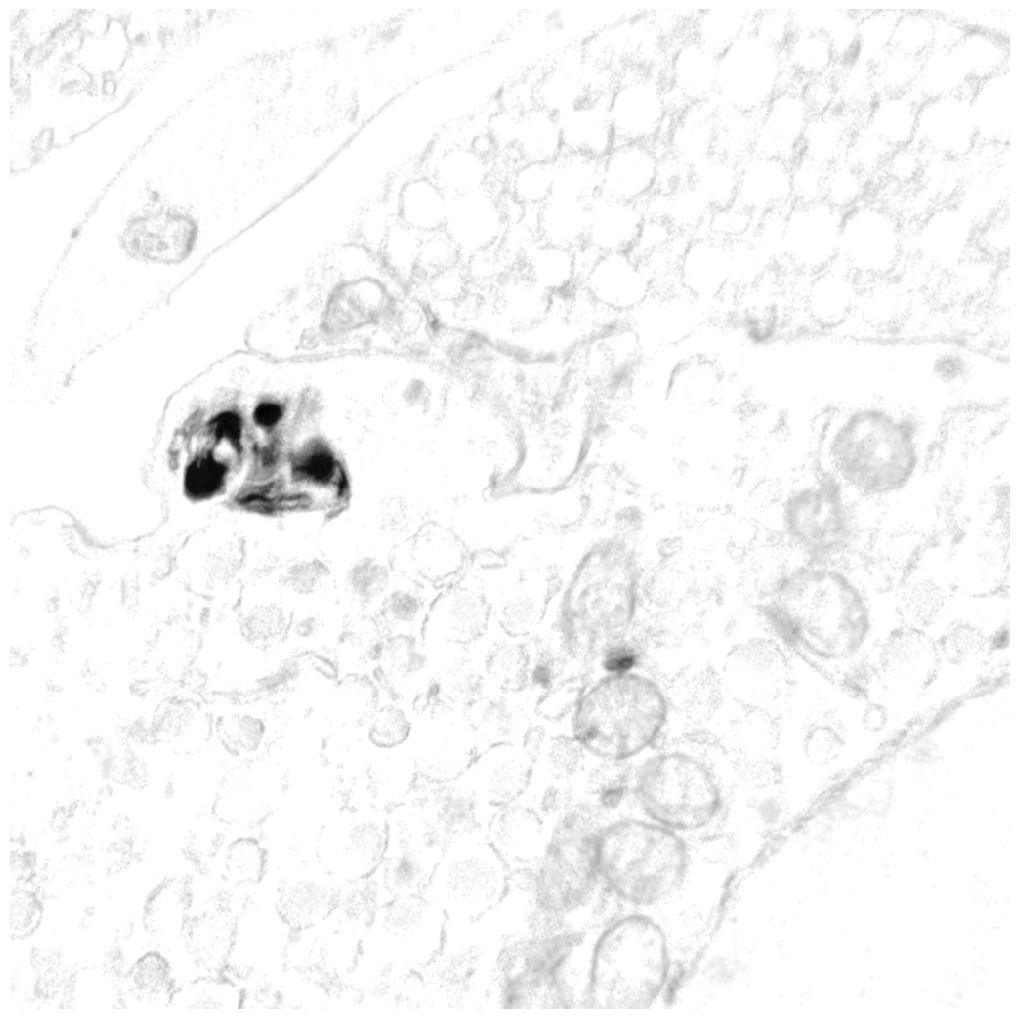

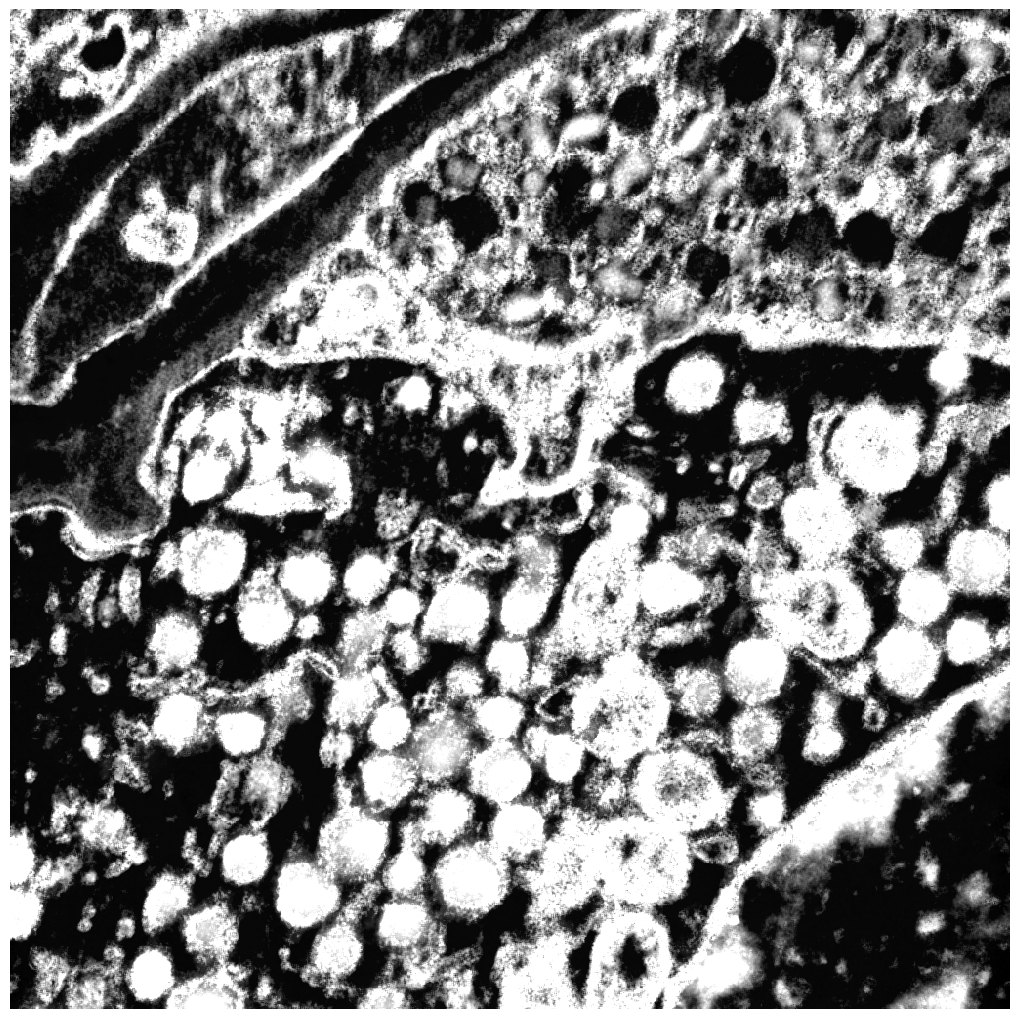

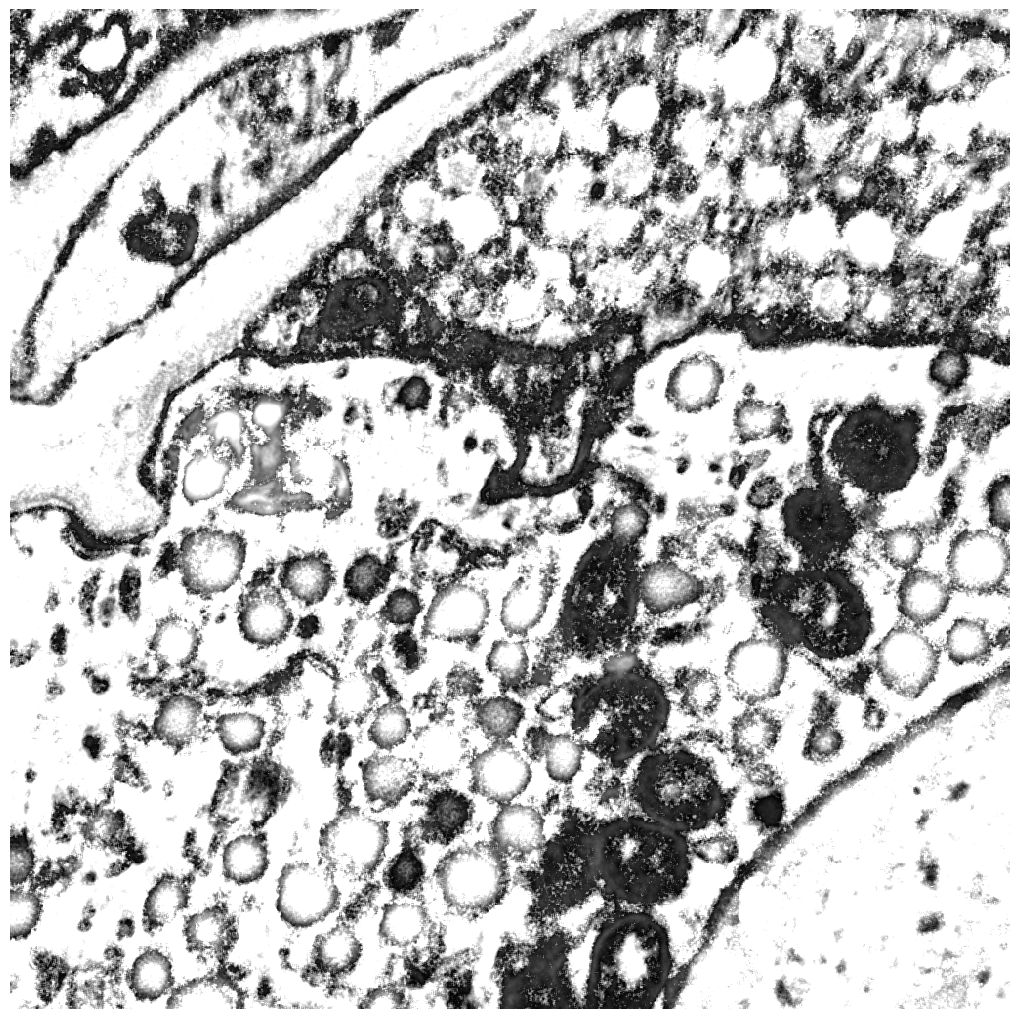

In [10]:
# Save
for em_idx in range(6):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    ax.imshow(End_maps[em_idx]*~overlap_corr(tile_idx=0,xy_dim=size_xy,rows=rows,cols=cols,overlap_ratio=0.20), interpolation='nearest',cmap='gray_r', vmin = 0)
    plt.axis('off')
    plt.savefig("../Results/handannotated_abundance_maps/%02d.png" % em_idx,dpi=300) #,bbox_inches='tight')